<a href="https://colab.research.google.com/github/nvvishnu/CS6910-Assignments/blob/main/Assignement1_Final_Sweep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import the necessary packages

!pip install wandb
import pandas as pd
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from matplotlib import pyplot
import math
from sklearn.model_selection import train_test_split
import seaborn as sns #To plot confusion matrix as a heatmap

     |████████████████████████████████| 2.0MB 6.7MB/s 
     |████████████████████████████████| 163kB 33.7MB/s 
     |████████████████████████████████| 133kB 24.9MB/s 
     |████████████████████████████████| 102kB 7.4MB/s 
     |████████████████████████████████| 71kB 5.2MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=bf1391ba76d3b65d3643fa9f1513ea8a2858436a901cfe5a2c5f08c9a8947293
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=b8729baa84dd7da13c486f9d4e47afd5d3cd506030df824bb7a4aea3a2348ab8
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [2]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data() #Loading the testing and training datset of fashion_mnist dataset
Xtrain = trainX
Ytrain = trainy
trainX, validateX, trainy, validatey = train_test_split(trainX,trainy, test_size=0.1, random_state=1) #Split trainining data into training and validation data

#Normalization of training date
trainX = trainX/255
testX = testX/255
validateX = validateX/255

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
#Logging into wandb; Intializing wandb with appropriate user name and project
!wandb login 
wandb.init(project="cs6910-assignment1", entity="nvvishnu")

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: nvvishnu (use `wandb login --relogin` to force relogin)


In [4]:
# The ten fashion class labels in fashion_mnist are as follows:

# T-shirt/top
# Trouser/pants
# Pullover shirt
# Dress
# Coat
# Sandal
# Shirt
# Sneaker
# Bag
# Ankle boot

names = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
images = []
labels = []

for i in range(Xtrain.shape[0]):
   if(len(labels) == 10):
      break
   if(names[Ytrain[i]] not in labels):
      images.append(Xtrain[i])
      labels.append(names[Ytrain[i]])
   
wandb.log({"DataSet Examples": [wandb.Image(image,caption=label) for image,label in zip(images,labels)]})

#Log sample images of each class to wandb


In [ ]:
#This cell contains the definition of helper functions

#Definition of sigmoid activation function
def logistic(z):
  l = []

  for i in z:
     if (i[0]<-600): #To handle overflows
       l.append(0)
     else:
       l.append(1./(1+math.exp(-i[0])))
  
  t = np.array(l)

  t = t.reshape(t.shape[0],1)

  return t

#Definition of ReLU activation function
def relu(z):
  l=[]
  for i in z:
    l.append(max(0,i[0]))
  t= np.array(l)
  t = t.reshape(t.shape[0],1)
  return t

#Function to calculate gradient of ReLU activation function  
def relu_grad(z):
  l=[]
  for i in z:
    if(i[0]<0):
      l.append(0)
    else:
      l.append(1)  
  t= np.array(l)
  t = t.reshape(t.shape[0],1)
  return t  

#Gradient of sigmoid activation function
def log_grad(z):
    return logistic(z)*(1-logistic(z))

#Definition of tanh activation function
def tanh(z):
    l = []
    for i in z:
      if (i[0]>=600): #Handle overflows
        l.append(1)
      elif (i[0]<=(-600)):
        l.append(-1)
      else:
        l.append((math.exp(i[0])-math.exp(-i[0]))/((math.exp(i[0])+math.exp(-i[0]))))
        
    t = np.array(l)
    t = t.reshape(t.shape[0],1)
    return t

#Gradient of tanh activation function
def tanh_grad(z):
  return 1-((tanh(z))*(tanh(z)))
  
#Function to calculate cross-entropy loss
def cross_entropy_loss(X_test,Y_test,weights,biases):
    sum = 0
    for i in range(Y_test.shape[0]):
      y_ = feed_forward(X_test[i],logistic,weights,biases)[2]
      if(Y_test[i]<y_.shape[0]):
        if(y_[Y_test[i]][0] != 0):
           sum = sum - math.log(y_[Y_test[i]][0])
        else:
           print("very bad\n")
           sum = sum + 100000

    return sum/Y_test.shape[0]

#Function to calculate accuracy
def accuracy(X_test,Y_test,weights,biases):
    
    sum = 0
    cnt = 0

    for i in range(Y_test.shape[0]):     
      y_ = feed_forward(X_test[i],logistic,weights,biases)[2]
      y_ = y_.flatten()
      #print(y_)
      j = np.argmax(y_)

      if (Y_test[i] == j):
        sum = sum+1

    return sum/Y_test.shape[0]

#Definition of softmax function
def softmax(arr):    
    l = []
    flag = False
    cnt = 0  
    y = []
    for i in range(arr.shape[0]) :  #Handle overflows
      if(arr[i][0]<=600):
         l.append(math.exp(arr[i][0]))
      else:
        flag = True
        cnt = cnt + 1
        y.append(i)

    if(flag):       
       temp = np.zeros(len(arr))    
       for it in y:
          temp[it] = 1.0/cnt;
       temp = temp.reshape(temp.shape[0],1)           
       return temp   
         
    if(np.sum(l) != 0):
      l = np.array(l)
      l = (l)/np.sum(l)
      l = l.reshape((l.shape[0],1))
      return l
    else:
       return (1.0/len(arr))*(np.ones(shape=(len(arr),1),dtype=float))

#Helper function to perform operation on list. We decided to use store weights and biases to be able to support different size for each hidden layer easily.
def upd_lst(lst1,lst2,operation,eeta): #Performs x 'operation' f(y) for each element x in lst1 and y in lst2. 'operation' - addition/subtraction/multiplication/square root of inverse
   l = []
   if(len(lst1)!=len(lst2)):
    print("Lists are not of equal length")
   for (x,y) in zip(lst1,lst2):
     if(operation == '+'):
       l.append(x+(eeta*y))
     elif(operation == '-'):
       l.append(x-(eeta*y))
     elif(operation == '*'):
       l.append(x*y*eeta*eeta)
     elif(operation == 'sqrt'):
      # print(x,y,eeta)
       l.append(x/np.sqrt(y+eeta))
     elif(operation=='mult'):
      l.append(x*eeta)

   return l

In [ ]:
#Feedforward neural network
def feed_forward(X,activation_function,weights,biases,output_function=softmax):
    
    X = X.copy()
    X = X.flatten()
    num_hidden_layers = len(biases)

    # X is the input (x1,x2,...,xn)
    # activation_function is just the activation function s.t h_i = activation_function(a_i)
    # weights is a list of m*n where n is number of neurons in previous layer and m is number of neurons in current layer assume 1 based indexing 
    # assuming output function O is softmax function
    # biases is list of  [b1,b2,..,bk] for each layer

    X = X.reshape((X.shape[0],1))
    a = []
    h = []
    
    for i in range(num_hidden_layers):
       if(i == 0):
         a.append(np.array(0))
         h.append(X)
       else:        
        a.append(np.matmul(weights[i],h[i-1])+biases[i])
        h.append(activation_function(a[len(a)-1]))
    return [a,h,output_function(a[len(a)-1])]    

In [ ]:
#Function to calculate gradients of cross entropy loss function with respect to weights and biases
def calculate_gradients(y_true,y_out,h,a,weights,act_fn_derivative,weight_decay,biases):
    
    #delta(A_l) = -(e_ytrue - y_out)
    #delta(h_i) = (W_i+1).Tdelta(A_i+1)  (for i = L-1 to 1)
    #delta(A_i) = delta(h_i)*(activation_function'(A_i)) for(i = L-1 to 1)
    #delta(W_k) = delta(A_k)(h_(k-1).T) for(i = L to i = 1)
    #delta(b_k) = delta(A_k)

    e = np.zeros(len(y_out))
    e = e.reshape(e.shape[0],1)
    e[y_true] = 1
    A = y_out-e
    l = len(h)
    delta_W = []
    delta_B = []
    
    delta_W.append(np.matmul(A,h[l-2].T))
    delta_B.append(A)
    l = l-2

    while(l >= 1):
       H = np.matmul(weights[l+1].T,A)
       A = H*(act_fn_derivative(a[l]))     # assuming a is 1 based index 
       delta_W.append(np.matmul(A,h[l-1].T))
       delta_B.append(A)
       l = l-1
    
    delta_W.append(0)
    delta_B.append(0)
    delta_W.reverse()
    delta_B.reverse()
    delta_W=upd_lst(delta_W,weights,'+',weight_decay)
    delta_B=upd_lst(delta_B,biases,'+',weight_decay)
    return [delta_W,delta_B]

    



In [ ]:
#This cell contains the definition of different optimizers

#sgd optimizer
def sgd(X,Y,num_epochs,weight_decay,learning_rate,batch_size,weights,biases,activation_function,act_fn_derivative):    
    for i in range(num_epochs): 
          cnt = 0
          cum_W = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
          cum_B = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]
          for j in range(X.shape[0]):

            cnt = cnt + 1
            r = feed_forward(X[j],activation_function,weights,biases)
            a = r[0]
            h = r[1]
            yout = r[2]
            gradients = calculate_gradients(Y[j],yout,h,a,weights,act_fn_derivative,weight_decay,biases)
            cum_W = upd_lst(cum_W,gradients[0],'+',1)
            cum_B = upd_lst(cum_B,gradients[1],'+',1)

            
            if(cnt == batch_size): 
                weights = upd_lst(weights,cum_W,'-',(learning_rate*(1.0))/batch_size)
                biases = upd_lst(biases,cum_B,'-',(learning_rate*(1.0))/batch_size)
                cum_W = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
                cum_B = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]
                cnt = 0
    return [weights,biases]

#adam optimizer
def adam(X,Y,num_epochs,weight_decay,learning_rate,batch_size,weights,biases,activation_function,act_fn_derivative):
    eps = 1e-8
    beta1 = 0.9
    beta2 = 0.999
    for i in range(num_epochs): 
          cnt = 0
          cum_W = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
          cum_B = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]
          m_W = cum_W
          m_B = cum_B
          v_W = cum_W
          v_B = cum_B
          a_cnt  = 0

          for j in range(X.shape[0]):
             cnt = cnt + 1
             r = feed_forward(X[j],activation_function,weights,biases)
             a = r[0]
             h = r[1]
             yout = r[2]

             gradients = calculate_gradients(Y[j],yout,h,a,weights,act_fn_derivative,weight_decay,biases)
             cum_W = upd_lst(cum_W,gradients[0],'+',1)
             cum_B = upd_lst(cum_B,gradients[1],'+',1)

             if(cnt == batch_size): 
                 m_W = upd_lst(m_W,m_W,'+',(beta1-1))   #m_W = beta1*m_W
                 m_W = upd_lst(m_W,cum_W,'+',(1-beta1)/batch_size)   #m_W += (1-beta1)*db

                 m_B = upd_lst(m_B,m_B,'+',(beta1-1))   #m_B = beta1*m_B
                 m_B = upd_lst(m_B,cum_B,'+',(1-beta1)/batch_size)   #m_B += (1-beta1)*db                

                 d_W_sqr = upd_lst(cum_W,cum_W,'*',1.0/batch_size)
                 d_B_sqr = upd_lst(cum_B,cum_B,'*',1.0/batch_size)

                 v_W = upd_lst(v_W,v_W,'+',(beta2-1))  #v_W = beta2*v_W
                 v_W = upd_lst(v_W,d_W_sqr,'+',(1-beta2))  #v_W += (1-beta2)*dwsqr

                 v_B = upd_lst(v_B,v_B,'+',(beta2-1))  #v_B = beta2*v_B
                 v_B = upd_lst(v_B,d_B_sqr,'+',(1-beta2))  #v_B += (1-beta2)*dbsqr
                 
                 t = math.pow(beta1,j+1)/(1-math.pow(beta1,a_cnt+1))
                 m_W_hat = upd_lst(m_W,m_W,'+',t)
                 m_B_hat = upd_lst(m_B,m_B,'+',t)

                 t = math.pow(beta2,j+1)/(1-math.pow(beta2,a_cnt+1))
                 v_W_hat = upd_lst(v_W,v_W,'+',t)
                 v_B_hat = upd_lst(v_B,v_B,'+',t)

                 
                 m_W_hat = upd_lst(m_W_hat,v_W_hat,'sqrt',eps) #m_W_hat = m_W_hat/(sqrt(v_W_hat+eps))
                 weights = upd_lst(weights,m_W_hat,'-',learning_rate)   #weights = weights - (learning rate)*m_W_hat/sqrt(v_W_hat+eps)

                 m_B_hat = upd_lst(m_B_hat,v_B_hat,'sqrt',eps) #m_B_hat = m_B_hat/sqrt(V_B_hat+eps)
                 biases = upd_lst(biases,m_B_hat,'-',learning_rate) #biases = biases - (learning rate)*m_B_hat/sqrt(v_B_hat+eps)

                 cum_W = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
                 cum_B = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]

                 cnt = 0
                 a_cnt = a_cnt + 1

    return [weights,biases]

#nadam optimizer
def nadam(X,Y,num_epochs,weight_decay,learning_rate,batch_size,weights,biases,activation_function,act_fn_derivative):
    
    eps = 1e-8
    beta1 = 0.9
    beta2 = 0.999
    for i in range(num_epochs): 

          cnt = 0
          cum_W = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
          cum_B = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]

          m_W = cum_W
          m_B = cum_B

          v_W = cum_W
          v_B = cum_B

          cum_W_m = cum_W
          cum_B_m = cum_B

          a_cnt  = 0
          for j in range(X.shape[0]):

             cnt = cnt + 1
             r = feed_forward(X[j],activation_function,weights,biases)
             a = r[0]
             h = r[1]
             yout = r[2]

             gradients = calculate_gradients(Y[j],yout,h,a,weights,act_fn_derivative,weight_decay,biases)
             cum_W = upd_lst(cum_W,gradients[0],'+',1)
             cum_B = upd_lst(cum_B,gradients[1],'+',1)
             
             weights_m = upd_lst(weights,m_W,'-',beta1)
             biases_m = upd_lst(weights,m_B,'-',beta1)
             
             r = feed_forward(X[j],activation_function,weights_m,biases_m)
             a = r[0]
             h = r[1]
             yout = r[2]

             gradients = calculate_gradients(Y[j],yout,h,a,weights_m,act_fn_derivative,weight_decay,biases)

             cum_W_m = upd_lst(cum_W_m,gradients[0],'+',1)
             cum_B_m = upd_lst(cum_B_m,gradients[1],'+',1)
             

             if(cnt == batch_size):
                 
                #  cum_W_m = upd_lst(cum_W_m,weights,'-',(weight_decay)*batch_size)
                #  cum_B_m = upd_lst(cum_B_m,biases,'-',(weight_decay)*batch_size)

                #  cum_W = upd_lst(cum_W,weights,'-',(weight_decay)*batch_size)
                #  cum_B = upd_lst(cum_B,biases,'-',(weight_decay)*batch_size)
                 
                 m_W = upd_lst(m_W,m_W,'+',(beta1-1))   #m_W = beta1*m_W
                 m_W = upd_lst(m_W,cum_W_m,'+',(1-beta1)/batch_size)   #m_W += (1-beta1)*db

                 m_B = upd_lst(m_B,m_B,'+',(beta1-1))   #m_B = beta1*m_B
                 m_B = upd_lst(m_B,cum_B_m,'+',(1-beta1)/batch_size)   #m_B += (1-beta1)*db
                 

                 d_W_sqr = upd_lst(cum_W,cum_W,'*',1.0/batch_size)
                 d_B_sqr = upd_lst(cum_B,cum_B,'*',1.0/batch_size)

                 v_W = upd_lst(v_W,v_W,'+',(beta2-1))  #v_W = beta2*v_W
                 v_W = upd_lst(v_W,d_W_sqr,'+',(1-beta2))  #v_W += (1-beta2)*dwsqr

                 v_B = upd_lst(v_B,v_B,'+',(beta2-1))  #v_B = beta2*v_B
                 v_B = upd_lst(v_B,d_B_sqr,'+',(1-beta2))  #v_B += (1-beta2)*dbsqr
                 
                 t = math.pow(beta1,j+1)/(1-math.pow(beta1,a_cnt+1))
                 m_W_hat = upd_lst(m_W,m_W,'+',t)
                 m_B_hat = upd_lst(m_B,m_B,'+',t)

                 t = math.pow(beta2,j+1)/(1-math.pow(beta2,a_cnt+1))
                # print(beta2,math.pow(beta2,a_cnt+1))
                 v_W_hat = upd_lst(v_W,v_W,'+',t)
                 v_B_hat = upd_lst(v_B,v_B,'+',t)

                 
                 m_W_hat = upd_lst(m_W_hat,v_W_hat,'sqrt',eps) #m_W_hat = m_W_hat/(sqrt(v_W_hat+eps))
                 weights = upd_lst(weights,m_W_hat,'-',learning_rate)   #weights = weights - (learning rate)*m_W_hat/sqrt(v_W_hat+eps)

                 m_B_hat = upd_lst(m_B_hat,v_B_hat,'sqrt',eps) #m_B_hat = m_B_hat/sqrt(V_B_hat+eps)
                 biases = upd_lst(biases,m_B_hat,'-',learning_rate) #biases = biases - (learning rate)*m_B_hat/sqrt(v_B_hat+eps)

                 cum_W = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
                 cum_B = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]

                 cum_W_m = cum_W
                 cum_B_m = cum_B

                 cnt = 0
                 a_cnt = a_cnt + 1


    return [weights,biases]
 
 #momentum optimizer
 def momentum(X,Y,num_epochs,weight_decay,learning_rate,batch_size,weights,biases,activation_function,act_fn_derivative):
  #update{t} = gamma . update_{t-1} + learning_rate * grad(weight)
  #weigt{t}=weight{t-1}-update{t}

  gamma=0.9 # The typical value of gamma used is 0.9
  for lmao in range(num_epochs):
    #Initialisation of weights_grad_tot, biases_grad_tot
    weights_grad_tot = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
    biases_grad_tot = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]

    #Initialisation of update_weights
    update_weights=weights_grad_tot
    update_biases=biases_grad_tot

    print(lmao)
    # num_hidden_layers=len(biases) #Biases is a list of 1D arrays. Thus, the number of hidden layers is given by the size of this list    
    num_data_point_done=0
    dum=0
    for x,y in zip(X,Y):  
      y_pred=feed_forward(x,activation_function,weights,biases)  #Find prediction for each data instance of the data set
      a = y_pred[0]
      h = y_pred[1]
      yout = y_pred[2]
      [weights_grad,biases_grad] =  calculate_gradients(y,yout,h,a,weights,act_fn_derivative,weight_decay,biases)
      weights_grad_tot = upd_lst(weights_grad_tot,weights_grad,'+',1)
      biases_grad_tot = upd_lst(biases_grad_tot,biases_grad,'+',1)
      num_data_point_done=num_data_point_done+1
      if(num_data_point_done==batch_size):
        
        update_weights = upd_lst(update_weights,update_weights,'+',gamma-1)
        update_biases = upd_lst(update_biases,update_biases,'+',gamma-1)
        update_weights=upd_lst(update_weights,weights_grad_tot,'+',learning_rate/batch_size)
        update_biases=upd_lst(update_biases,biases_grad_tot,'+',learning_rate/batch_size)
       
        weights=upd_lst(weights,update_weights,'-',1.0)
        biases=upd_lst(biases,update_biases,'-',1.0)
        num_data_point_done=0
        weights_grad_tot = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
        biases_grad_tot = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]
  return [weights,biases]

#nesterov optimiser 
def nesterov(X,Y,num_epochs,weight_decay,learning_rate,batch_size,weights,biases,activation_function,act_fn_derivative):
  #w_ahead=w_{t} - gamma. update_{t-1}
  #update{t} = gamma . update_{t-1} + learning_rate * grad(w_lookahead)

  gamma=0.9 # The typical value of gamma used is 0.9

  #Initialisation of weights_grad_tot, biases_grad_tot
  weights_grad_tot = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
  biases_grad_tot = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]

  #Initialisation of update_weights
  update_weights=weights_grad_tot
  update_biases=biases_grad_tot  
  for lmao in range(num_epochs):

    # num_hidden_layers=len(biases) #Biases is a list of 1D arrays. Thus, the number of hidden layers is given by the size of this list    
    num_data_point_done=0
    w_ahead=weights # Initial value of w_ahead is weights
    b_ahead=biases

    for x,y in zip(X,Y):  
      y_pred=feed_forward(x,activation_function,w_ahead,b_ahead)  #Find prediction for each data instance of the data set
      a = y_pred[0]
      h = y_pred[1]
      yout = y_pred[2]

      [weights_grad,biases_grad] =  calculate_gradients(y,yout,h,a,w_ahead,act_fn_derivative,weight_decay,b_ahead)
      weights_grad_tot = upd_lst(weights_grad_tot,weights_grad,'+',1)
      biases_grad_tot = upd_lst(biases_grad_tot,biases_grad,'+',1)   
      num_data_point_done=num_data_point_done+1

      if(num_data_point_done==batch_size):
        # weights_grad_tot = upd_lst(weights_grad_tot,weights,'-',(weight_decay)*batch_size)
        # biases_grad_tot = upd_lst(biases_grad_tot,biases,'-',(weight_decay)*batch_size)

        w_ahead=upd_lst(weights,update_weights,'-',gamma)
        b_ahead=upd_lst(biases,update_biases,'-',gamma)

        update_weights = upd_lst(update_weights,update_weights,'+',gamma-1)
        update_biases = upd_lst(update_biases,update_biases,'+',gamma-1)

        update_weights=upd_lst(update_weights,weights_grad_tot,'+',learning_rate/batch_size)
        update_biases=upd_lst(update_biases,biases_grad_tot,'+',learning_rate/batch_size)

        # update_weights = update_weights + gamma*update_weights + learning_rate * weights_grad_tot
        # update_biases = update_biases + gamma*update_weight + learning_rate * biases_grad_tot

        weights=upd_lst(weights,update_weights,'-',1.0)
        biases=upd_lst(biases,update_biases,'-',1.0)
        num_data_point_done=0

        weights_grad_tot = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
        biases_grad_tot = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]
  return [weights,biases]


#This is additional attempt to implement adagrad optimizer(Note that the definition is not complete) 
# def adagrad(X,Y,num_epochs,weight_decay,learning_rate,batch_size,weights,biases,activation_function,gamma,act_fn_derivative):
#   #w_ahead=w_{t} - gamma. update_{t-1}
#   #update{t} = gamma . update_{t-1} + learning_rate * grad(w_lookahead)
#   # w_ahead= weights
#   # b_ahead=biases
#   for i in range(num_epochs):
#     # num_hidden_layers=biases.size()[0] #Biases is a list of 1D arrays. Thus, the number of hidden layers is given by the size of this list
#     Y_pred=feed_forward(X,activation_function,weights,biases) #Find prediction for each data instance of the data set
#     weights_grad_tot=[]
#     for w in weights:
#       weights_grad_tot.append(np.zeroes(w.size()))
#     biases_grad_tot=[]
#     for b in biases:
#       biases_grad_tot.append(np.zeroes(b.size()))
#     num_data_point_done=0
#     v_weight = 0 #Intitial value of 0
#     v_bias=0
#     epsilon = 0 #Figure out what is epsilon
#     for x,y,y_pred in zip(X,Y,Y_pred):    
#       [weights_grad,biases_grad] =  calculate_gradient(y,y_pred,h,a,weights,act_fn_derivative)
#       weights_grad_tot = weights_grad_tot+weights_grad
#       biases_grad_tot = biases_grad_tot + biases_grad
#       num_data_point_done=num_data_point_done+1
#       if(num_data_point_done==batch_size):
#         v_weight = v_weight + (weights_grad_total)**2
#         v_bias = v_bias + (biases_grad_total)**2
#         v_weight_dum = learning_rate/np.sqrt(v_weight+epsilon)
#         v_bias_dum = learning_rate/np.sqrt(v_bias+epsilon)
#         weights=weights- v_weight_dum * weights_grad_tot
#         biases=biases - v_bias_dum * bias_grad_tot
#         num_data_point_done=0

#rmsprop optimizer  
def rmsprop(X,Y,num_epochs,weight_decay,learning_rate,batch_size,weights,biases,activation_function,act_fn_derivative):
  beta=0.9 # The typical value of beta used is 0.9
  epsilon = 1e-8  # Typical value of epsilon used

  for lmao in range(num_epochs):

    #Initialisation of weights_grad_tot, biases_grad_tot
    weights_grad_tot = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
    biases_grad_tot = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]
    v_weight = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
    b_weight = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]   

    # num_hidden_layers=len(biases) #Biases is a list of 1D arrays. Thus, the number of hidden layers is given by the size of this list    
    num_data_point_done=0

    for x,y in zip(X,Y):  
    
      y_pred=feed_forward(x,activation_function,weights,biases)  #Find prediction for each data instance of the data set
      a = y_pred[0]
      h = y_pred[1]
      yout = y_pred[2]

      [weights_grad,biases_grad] =  calculate_gradients(y,yout,h,a,weights,act_fn_derivative,weight_decay,biases)
      weights_grad_tot = upd_lst(weights_grad_tot,weights_grad,'+',1)
      biases_grad_tot = upd_lst(biases_grad_tot,biases_grad,'+',1)
      num_data_point_done=num_data_point_done+1

      if(num_data_point_done==batch_size):   
        # weights_grad_tot = upd_lst(weights_grad_tot,weights,'-',(weight_decay)*batch_size)
        # biases_grad_tot = upd_lst(biases_grad_tot,biases,'-',(weight_decay)*batch_size)

        v_weight = upd_lst(v_weight,v_weight,'+',(beta-1))
        dum1=upd_lst(weights_grad_tot,weights_grad_tot,'*',1.0/batch_size)

        v_weight= upd_lst(v_weight,dum1,'+',(1-beta))
        b_weight = upd_lst(b_weight,b_weight,'+',(beta-1))

        dum2=upd_lst(biases_grad_tot,biases_grad_tot,'*',1.0/batch_size)
        b_weight= upd_lst(b_weight,dum2,'+',(1-beta))

        weights_grad_tot=upd_lst(weights_grad_tot,weights_grad_tot,'mult',1.0/batch_size)
        v_weight_dum=upd_lst(weights_grad_tot,v_weight,'sqrt',epsilon)
        weights=upd_lst(weights, v_weight_dum,'-',learning_rate)
        biases_grad_tot=upd_lst(biases_grad_tot,biases_grad_tot,'mult',1.0/batch_size)

        b_weight_dum=upd_lst(biases_grad_tot,b_weight,'sqrt',epsilon)
        biases=upd_lst(biases, b_weight_dum,'-',learning_rate)       
        num_data_point_done=0

        weights_grad_tot = [np.zeros(weights[i].shape) if(i != 0) else 0 for i in range(len(weights))]
        biases_grad_tot = [np.zeros(biases[i].shape) if(i != 0) else 0 for i in range(len(biases))]
  return [weights,biases]        


IndentationError: ignored

In [ ]:
#Definition of the backpropogation framework
def backpropagation(X,Y,num_epochs,num_hidden_layers,sz_hidden_layer,learning_rate,optimizer,batch_size,weight_initialisation,activation,weight_decay,validateX,validatey):
    
    
    weights = [0]  #dummy value
    biases =  [0]  #dummy value 
    
    #Initiliase activation function and gradient of activation function
    if(activation=='sigmoid'):
      activation_function=logistic
      act_fn_derivative=log_grad
    elif(activation=='tanh'):
      activation_function=tanh
      act_fn_derivative=tanh_grad
    elif(activation=='ReLU'):
      activation_function=relu
      act_fn_derivative=relu_grad

    #Weight initialisation
    if (weight_initialisation == 'random'):        
        num_classes = len(np.unique(Y))
        i = len(X[0].flatten())
        a = -1
        b = 1

        for j in range(num_hidden_layers-1):
            weights.append((b-a)*np.random.rand(sz_hidden_layer,i)+a)
            biases.append(np.zeros((sz_hidden_layer,1)))
            i = sz_hidden_layer
        weights.append((b-a)*np.random.rand(num_classes,i)+a)
        biases.append(np.zeros((num_classes,1)))

    else:

        #Xavier initilization
        num_classes = len(np.unique(Y))
        i = len(X[0].flatten())

        for j in range(num_hidden_layers-1):
            t = math.sqrt(6)/math.sqrt(i + sz_hidden_layer)
            weights.append(np.random.uniform(-t,t,(sz_hidden_layer,i)))
            biases.append(np.zeros((sz_hidden_layer,1)))
            i = sz_hidden_layer
        
        t = math.sqrt(6)/math.sqrt(i + num_classes)
        weights.append(np.random.uniform(-t,t,(num_classes,i)))
        biases.append(np.zeros((num_classes,1)))

    #Use the appropriate optimiser
    fun = 1
    if (optimizer == 'sgd'):
        fun = sgd
    elif (optimizer == 'momentum'):
        fun = momentum
    elif (optimizer == 'nesterov'):
        fun = nesterov
    elif (optimizer == 'rmsprop'):
        fun = rmsprop
    elif (optimizer == 'adam'):
        fun = adam
    elif (optimizer == 'nadam'):
        fun = nadam
    
    xvalues = []
    yvalues = []
    
    for i in range(num_epochs):
      [weights,biases] = fun(X,Y,1,weight_decay,learning_rate,batch_size,weights,biases,activation_function,act_fn_derivative) #backpropagation(trainX,trainy,1,config.num_hidden_layer,config.size_layer,config.learning_rate,config.optimizer,config.batch_size,config.weight_intialisation,config.activation,config.weight_decay)
      print('val_accuracy'+str(accuracy(validateX,validatey,weights,biases)))
      print('val_loss'+str(cross_entropy_loss(validateX,validatey,weights,biases)))
      print('accuracy'+str(accuracy(X,Y,weights,biases)))
      print('loss'+str(cross_entropy_loss(X,Y,weights,biases)))
      # wandb.log({'epoch':i})
      # wandb.log({'val_accuracy':accuracy(validateX,validatey,weights,biases)})
      # wandb.log({'val_loss':cross_entropy_loss(validateX,validatey,weights,biases)})
      # wandb.log({'accuracy':accuracy(X,Y,weights,biases)})
      # wandb.log({'loss':cross_entropy_loss(X,Y,weights,biases)})
      # wandb.log({'epoch':i})
    return [weights,biases]



In [ ]:
#This cell contains commented code that was used to debug our code

# import warnings
# warnings.simplefilter('error', RuntimeWarning) # To help debug where the warnings are
#backpropagation(X,Y,num_epochs,num_hidden_layers,sz_hidden_layer,learning_rate,optimizer,batch_size,weight_initialisation,activation,weight_decay):
#[weights,biases] = backpropagation(trainX,trainy,5,3,32,1e-3,'sgd',16,'random','sigmoid',0) #logistic,log_grad)
# # [weights_momentum,biases_momentum] = backpropagation(trainX/255,trainy,5,3,32,0,1e-3,'momentum',16,'random',logistic,log_grad)
#def backpropagation(X,Y,num_epochs,num_hidden_layers,sz_hidden_layer,learning_rate,optimizer,batch_size,weight_initialisation,activation,weight_decay,validateX,validatey):
# backpropagation(trainX,trainy,5,3,32,1e-3,'nesterov',64,'random','sigmoid',0.0005,validateX,validatey)
# #[weights_rmsprop,biases_rmsprop] = backpropagation(trainX/255,trainy,5,3,32,0,1e-3,'rmsprop',16,'random',logistic,log_grad)
# #t = cross_entropy_loss(testX, testy,weights,biases)
# # t_cross_momentum = cross_entropy_loss(testX, testy,weights_momentum,biases_momentum)
# #t_cross_nestrov = cross_entropy_loss(testX, testy,weights_nestrov,biases_nestrov)
# # t_cross_rmsprop = cross_entropy_loss(testX, testy,weights_rmsprop,biases_rmsprop)

# #print(t)
# # print(t_cross_momentum)
# #print(t_cross_nestrov)
# print(t_cross_rmsprop)

# #t = accuracy(testX, testy,weights,biases)
# # t_momentum=accuracy(testX, testy,weights_momentum,biases_momentum)
# #t_nestrov=accuracy(testX, testy,weights_nestrov,biases_nestrov)
# t_rmsprop=accuracy(testX, testy,weights_rmsprop,biases_rmsprop)
# #print(t)
# # # print(t_momentum)
# # print(t_rmsprop)



# backpropagation(X,Y,num_epochs,num_hidden_layers,sz_hidden_layer,learning_rate,optimizer,batch_size,weight_initialisation,activation,weight_decay,validateX,validatey):

# [weights,biases] = backpropagation(trainX,trainy,10,3,64,0.001,'adam',64,'random','sigmoid',0.0005,validateX,validatey)

# t = cross_entropy_loss(testX, testy,weights_nestrov,biases_nestrov)
# print(t)
# t = accuracy(testX, testy,weights_nestrov,biases_nestrov)
# print(t)
# [weights,biases] = backpropagation(trainX,trainy,5,3,32,0,1e-3,'sgd',16,'xavier',logistic,log_grad)
# t = cross_entropy_loss(testX, testy,weights,biases)
# print(t)

# t = accuracy(testX, testy,weights,biases)
# print(t)

# [weights,biases] = backpropagation(trainX,trainy,5,3,32,0,1e-3,'sgd',16,'xavier',tanh,tanh_grad)
# t = cross_entropy_loss(testX, testy,weights,biases)
# print(t)
# t = accuracy(testX, testy,weights,biases)
# print(t)

#The recommended set of parameters
# num_epochs = [5,10,15]

# weight_decay = [0,0.0005,0.5]
# learning_rate = [1e-3,1e-4]
# optimiser = ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
# batch_size =[16, 32, 64]

# activation= ['sigmoid', 'tanh', 'ReLU']

# weight_initialisation = [ 'random', 'Xavier']
# num_hidden_layer = [3,4,5]
# size_layer = [32,64,128]

In [ ]:
#Set the configuration for wandb sweep
sweep_config = {
    'name': 'max_accuracy_1.2',
    'method' : 'random',
    'metric': {        
         'goal': 'maximize',
         'name' : 'val_accuracy'
    },
    'parameters': {
        'epochs':{
            'values': [10]
        },
        'batch_size':{
            'values': [64]
        },
        'weight_decay':{
            'values': [0.0005]
        },
        'learning_rate':{
            'values': [0.001]
        },
        'optimizer':{
            'values': ['adam']
        },
        'activation':{
            'values': ['sigmoid']
        },
        'weight_intialisation':{
            'values': ['random']
        },
        'num_hidden_layer': {
            'values': [5]
        },
        'size_layer':{
            'values': [128]
        }

    }
}

In [ ]:
#The function which is to be sweeped by wandb
def train():
  config_default = {
        'epochs': 10,
        'batch_size': 64,
        'weight_decay':0.0005, 
        'learning_rate':0.001,
        'optimizer': 'adam',
        'activation': 'sigmoid', 
        'weight_intialisation':'random', 
        'num_hidden_layer': 5,
        'size_layer': 128
  }
  print("wand about to be initialised")
  #config=wandb.config
  #name = 'epochs_'+str(config.epochs)+'_btch_sz_'+str(config.batch_size)+'_wght_dcy_'+str(config.weight_decay)+'_optm_'+config.optimizer+'_lrng_rat_'+config.learning_rate+'_actvn_'+config.activation+'_numhdnlyr_'+str(config.num_hidden_layer)+' sz_lyr_'+str(config.size_layer)
  wandb.init(config=config_default,project='cs6910-assignment1')
  config = wandb.config
  a = trainX
  b = trainy
  
  backpropagation(trainX,trainy,config.epochs,config.num_hidden_layer,config.size_layer,config.learning_rate,config.optimizer,config.batch_size,config.weight_intialisation,config.activation,config.weight_decay,validateX,validatey) 

In [ ]:
#Commented code used to check our code

#agent=wandb.init(entity="nvvishnu",project="cs6910-assignment1")
# sweep_config['parameters']['epochs']
# # # import warnings
# # # warnings.simplefilter('error', RuntimeWarning) # To help debug where the warnings are

In [ ]:
#Create a sweep and generate sweep id
sweep_id = wandb.sweep(sweep_config,entity="nvvishnu",project="cs6910-assignment1")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: vb52k0il
Sweep URL: https://wandb.ai/nvvishnu/cs6910-assignment1/sweeps/vb52k0il


In [ ]:
#Run wandb agent to sweep
wandb.agent(sweep_id,project="cs6910-assignment1",function=train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: ot4gebxl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: adam
wandb: 	size_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_intialisation: random


wand about to be initialised


wandb: WARNING Ignored wandb.init() arg project when running a sweep


0
0
0
0
0
0
0
0
0
0


epoch,9
_runtime,7360
_timestamp,1615637051
_step,59
val_accuracy,0.8635
val_loss,0.38837
accuracy,0.87815
loss,0.34936


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▃▄▄▅▆▆▇██
val_loss,█▆▅▄▄▃▂▂▁▁
accuracy,▁▃▃▄▅▆▆▇██
loss,█▆▅▄▄▃▂▂▁▁


wandb: Agent Starting Run: 5trei2ti with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: adam
wandb: 	size_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_intialisation: random


wand about to be initialised


wandb: WARNING Ignored wandb.init() arg project when running a sweep


0


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
#Definition of function to plot confusion matrix
def confusion_matrix(X_test,Y_test,weights,biases):

    conf_mtrx = np.zeros(shape=(10,10))

    for i in range(Y_test.shape[0]):

        y_ = feed_forward(X_test[i],logistic,weights,biases)[2]
        y_ = y_.flatten()
        #print(y_)
        j = np.argmax(y_)
        conf_mtrx[Y_test[i]][j] = conf_mtrx[Y_test[i]][j] + 1
    
    return conf_mtrx
    
# [weights,biases] = backpropagation(trainX,trainy,5,3,32,1e-3,'sgd',16,'random','sigmoid',0)
conf_mtrx = confusion_matrix(testX, testy,weights,biases)
   

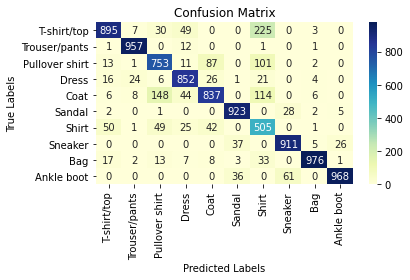

In [ ]:
#Generate heatmap for confusion matrix

names = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
# confusion_plot=pyplot.axes()
confusion_matrix=sns.heatmap(conf_mtrx.transpose(),linecolor= 'white', cbar=True,cmap="YlGnBu",annot=True,fmt=".0f",xticklabels=names,yticklabels=names)
pyplot.xlabel('Predicted Labels')
pyplot.ylabel('True Labels')
pyplot.title('Confusion Matrix')
pyplot.tight_layout()
# confusion_matrix=pyplot.show()
pyplot.savefig('confustion_matrix.png')

In [ ]:
#Print the test accuracy for the best model
cnt=0
for i in range(10):
  cnt+=conf_mtrx[i][i]
print(cnt/testy.shape[0])

0.8577


In [ ]:
#Used to store the optimal weights and biases so that they can re-used when runtime is reconnected
!pip install pickle-mixin
import pickle
weight_name = "weights.pkl"
open_file = open(weight_name, "wb")
pickle.dump(weights, open_file)
open_file.close()
biases_name = "biases.pkl"
open_file = open(biases_name, "wb")
pickle.dump(biases, open_file)
open_file.close()
open_file = open(weight_name, "rb")
weight_dum = pickle.load(open_file)
open_file.close()
open_file = open(biases_name, "rb")
biases_dum = pickle.load(open_file)
open_file.close()

  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-cp37-none-any.whl size=5999 sha256=7f4489749e3e419cd4503fc2c5fc2ba814b91a3bf5ae5cc6f2c2dc335a484d51
  Stored in directory: /root/.cache/pip/wheels/cd/05/42/71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin


In [ ]:
#Commented Code to check our code

# conf_mtrx_dum = confusion_matrix(testX, testy,weight_dum,biases_dum)
# cnt=0
# for i in range(10):
#   cnt+=conf_mtrx_dum[i][i]
print(cnt/testy.shape[0])
# with open("weights.txt", "w") as f:
#     for s in :
#         f.write(str(s) +"\n")
# with open("biases.txt", "w") as f:
#     for s in biases:
#         f.write(str(s) +"\n")
# weight_dum=[]
# with open("weights.txt", "r") as f:
#   for line in f:
#     weight_dum.append((line.strip()))
# # weight_dum=weight_dum.astype(np.float)
# biases_dum=[]
# with open("file.txt", "r") as f:
#   for line in f:
#     biases_dum.append(float(line.strip()))
# print(weight_dum)